# Time Series Model for Iron Production in Australia Using Python
### David Lowe
### November 20, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. https://machinelearningmastery.com/

SUMMARY: The purpose of this project is to construct a time series prediction model and document the end-to-end steps using a template. The Iron Production in Australia dataset is a time series situation where we are trying to forecast future outcomes based on past data points.

INTRODUCTION: The problem is to forecast the monthly basic iron production in Australia. The dataset describes a time-series of weight (in thousand tons) over 40 years (1956-1995), and there are 476 observations. We used the first 80% of the observations for training and testing various models while holding back the remaining observations for validating the final model.

ANALYSIS: The baseline prediction (or persistence) for the dataset resulted in an RMSE of 41.096. After performing a grid search for the most optimal ARIMA parameters, the final ARIMA non-seasonal order was (1, 1, 1) with the seasonal order being (1, 0, 1, 12). Furthermore, the chosen model processed the validation data with an RMSE of 34.639, which was better than the baseline model as expected.

CONCLUSION: For this dataset, the chosen ARIMA model achieved a satisfactory result and should be considered for further modeling.

Dataset Used: Monthly basic iron production in Australia January 1956 through August 1995

Dataset ML Model: Time series forecast with numerical attributes

Dataset Reference: Rob Hyndman and Yangzhuoran Yang (2018). tsdl: Time Series Data Library. v0.1.0. https://pkg.yangzhuoranyang./tsdl/.

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end
* Explore data cleaning and transformation options
* Explore various algorithms for baselining the model performance
* Explore tuning techniques for improving the model performance

A time series predictive modeling project genrally can be broken down into about five major tasks:

1. Define Problem and Acquire Data
2. Inspect and Explore Data
3. Clean and Pre-Process Data
4. Fit and Evaluate Models
5. Finalize Model

## Section 1. Define Problem and Acquire Data

### 1.a) Load Libraries

In [1]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import smtplib
import pmdarima as pm
from datetime import datetime
from email.message import EmailMessage
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

### 1.b) Set up the controlling parameters and functions

In [3]:
# Create the random seed number for reproducible results
seedNum = 888

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose = False

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

In [4]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python ARIMA Time Series Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [5]:
if (notifyStatus): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Acquire and Load the Data

Since the dataset is not current, this means that we cannot easily collect updated data to validate the model. Therefore, we will withhold a portion of the data towards the end from analysis and model selection. This very segment of data will be used to validate the final model.

In [6]:
startTimeScript = datetime.now()

In [7]:
# load the dataset and the necessary data structure
time_series = pd.read_csv('https://github.com/daines-analytics/datasets-public/raw/master/time-series-data-library/tsdl096.csv', index_col='idx', parse_dates=True)

# Sample code for subsetting the time-series data
# time_series = original_series['1986':'1990']

In [8]:
target_col = time_series.columns[0]
lower_bound = 'lower ' + target_col
upper_bound = 'upper ' + target_col
print('The target column of the time series is:', target_col)
print('The forecast boundary columns are:', lower_bound, '&', upper_bound)

The target column of the time series is: values
The forecast boundary columns are: lower values & upper values


In [9]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476 entries, 1956-01-01 to 1995-08-01
Data columns (total 1 columns):
values    476 non-null int64
dtypes: int64(1)
memory usage: 7.4 KB


In [10]:
time_series.head(10)

,values
idx,
1956-01-01,172
1956-02-01,166
1956-03-01,175
1956-04-01,171
1956-05-01,184
1956-06-01,175
1956-07-01,183
1956-08-01,154
1956-09-01,182


In [11]:
time_series.tail(10)

,values
idx,
1994-11-01,627
1994-12-01,590
1995-01-01,637
1995-02-01,563
1995-03-01,634
1995-04-01,605
1995-05-01,619
1995-06-01,595
1995-07-01,625


In [12]:
if (notifyStatus): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2. Inspect and Explore Data

In [13]:
if (notifyStatus): email_notify("Data Inspection and Exploration has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Summary Statistics of the Time Series Data

Summary statistics provide a quick look at the limits of observed values. It can help to get a quick idea of what we are working with.

In [14]:
# Summary statistics of time series
print(time_series.describe())

           values
count  476.000000
mean   460.313025
std    142.790921
min    154.000000
25%    363.250000
50%    489.500000
75%    567.000000
max    711.000000


### 2.b) Line Plot of the Time Series Data

A line plot of a time series can provide a lot of insight into the problem. Some observations from the plot can include:

* Whether the trend appears to be level around the mean
* Whether there appear to be any obvious outliers

The ARIMA(p,d,q) model requires three parameters and assumes that we are working with a stationary time series.

The ADF results should show that the test statistic value is smaller than the critical value at 5% if the time series is stationary. This suggests that we can reject the null hypothesis (i.e. a low probability that the result is a statistical fluke).

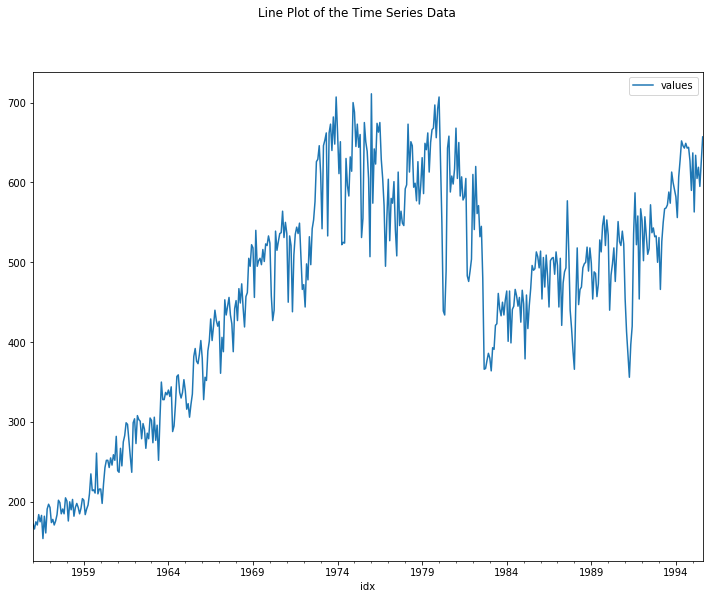

In [15]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Time Series Data')
time_series.plot(ax=ax)
plt.show()

### 2.c) Histogram and Density Plots of the Time Series Data

Reviewing plots of the density of observations can provide further insight into the structure of the data. Some observations from the plots can include:

* Whether the distribution is Gaussian
* Whether the distribution has a long tail and may suggest the need for data transformation

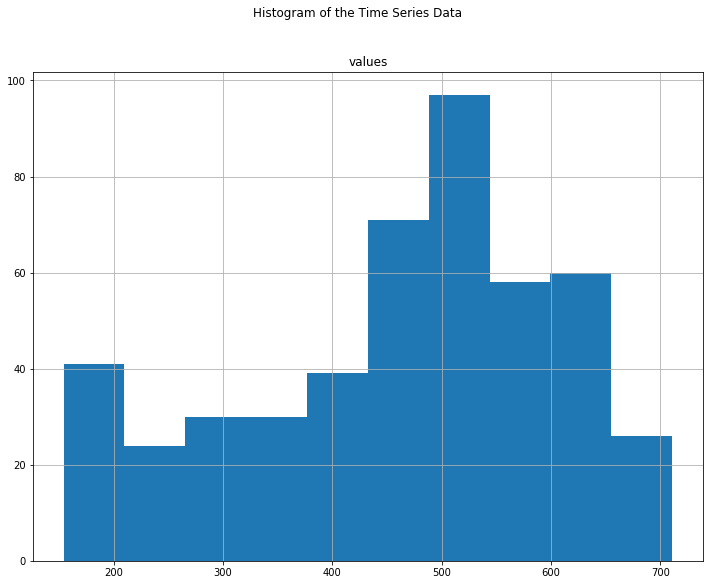

In [16]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Histogram of the Time Series Data')
time_series.hist(ax=ax)
plt.show()

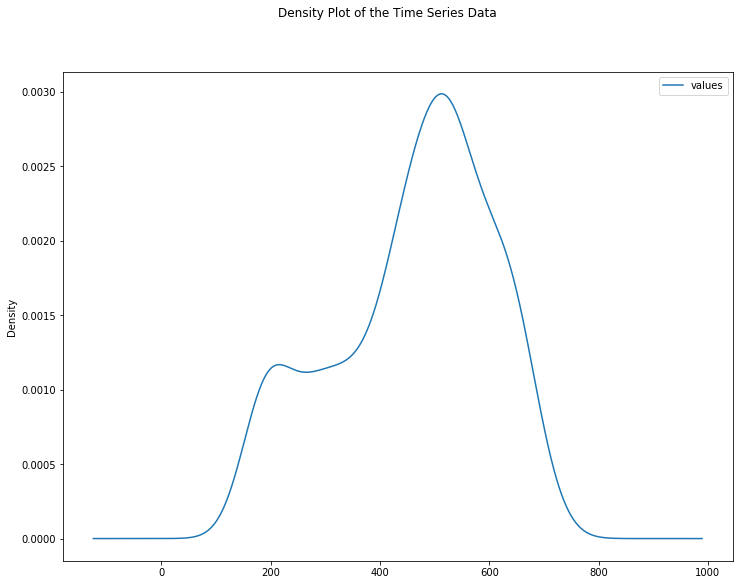

In [17]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Density Plot of the Time Series Data')
time_series.plot(kind='kde', ax=ax)
plt.show()

### 2.d) Box and Whisker Plots of the Time Series Data

We can group or aggregate the data and get a better idea of the spread of observations. Some observations from reviewing the plot can include:

* Whether the median values for each grouping shows any significant trend
* Whether the spread, or middle 50% of the data, shows any significant variability
* Whether there are outliers in some grouping

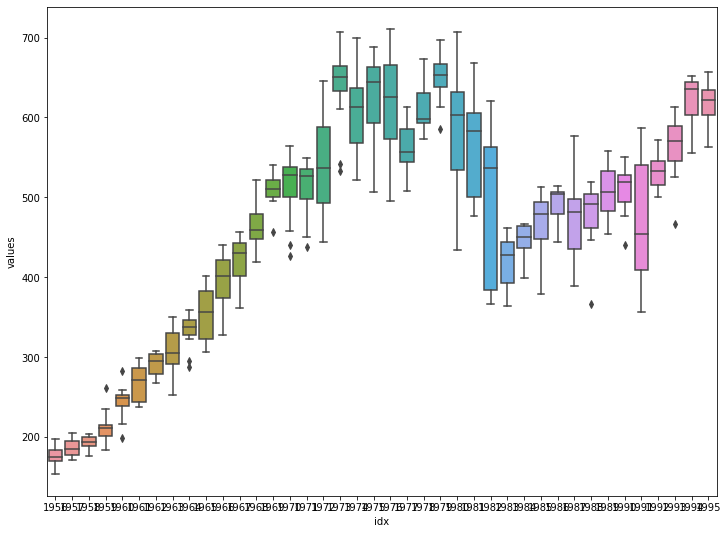

In [18]:
# boxplots of time series
fig, ax = plt.subplots(figsize=(12,9))
squeezed = time_series.squeeze()
sns.boxplot(squeezed.index.year, squeezed, ax=ax)
plt.show()

In [19]:
if (notifyStatus): email_notify("Data Inspection and Exploration completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3. Data Transformation and Stationarity Tests

In [20]:
if (notifyStatus): email_notify("Data Cleaning and Pre-Processing has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### Section 3.a) Data Transformation

In [21]:
# Resampling the time series into monthly average for the ease of modeling
# original_series = time_series
# resample = original_series.resample('M')
# time_series = resample.mean()
# time_series.head(10)

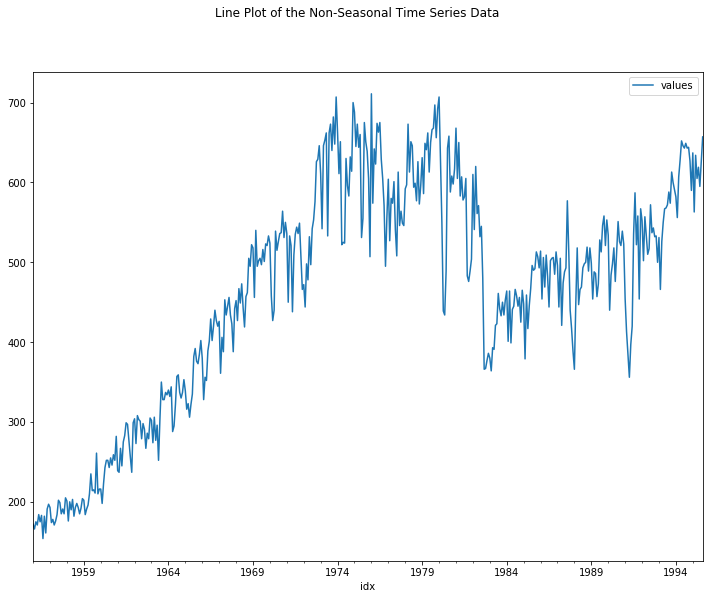

In [22]:
# Line plots of the transformed time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Non-Seasonal Time Series Data')
time_series.plot(ax=ax)
plt.show()

### Section 3.b) Test for Stationarity

In [23]:
# Check if stationary
result = adfuller(time_series[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.773329
p-value: 0.393781
Critical Test Statistics Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


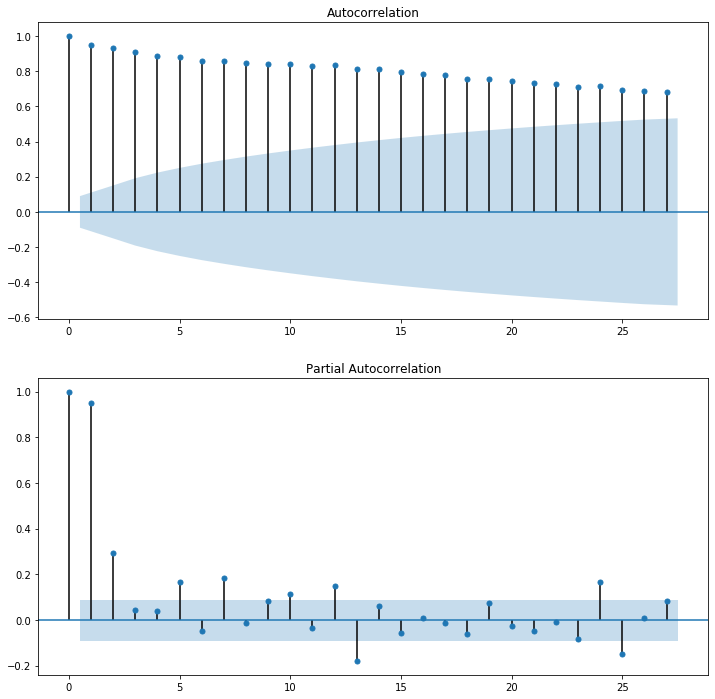

In [24]:
# ACF and PACF plots of the time series data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(time_series, ax=ax1)
plot_pacf(time_series, ax=ax2)
plt.show()

### 3.c) Test for Stationarity of Non-Seasonal Time Series Data

Occasionally a time series may look non-stationary on the first look. We can make it stationary by differencing the series and using a statistical test to confirm that the differenced result is stationary. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

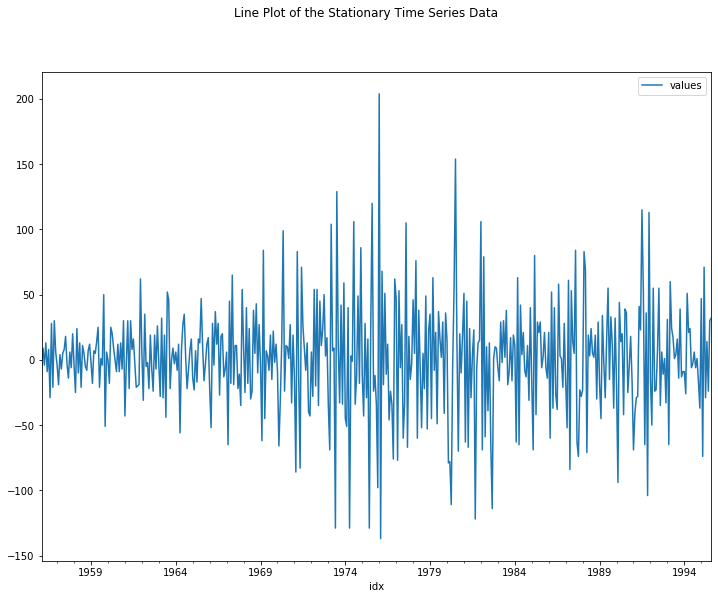

In [25]:
# Create a differenced series
stationary_ns = time_series.diff().dropna()

# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Time Series Data')
stationary_ns.plot(ax=ax)
plt.show()

In [26]:
# Check for stationarity
result = adfuller(stationary_ns[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.620878
p-value: 0.000000
Critical Test Statistics Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


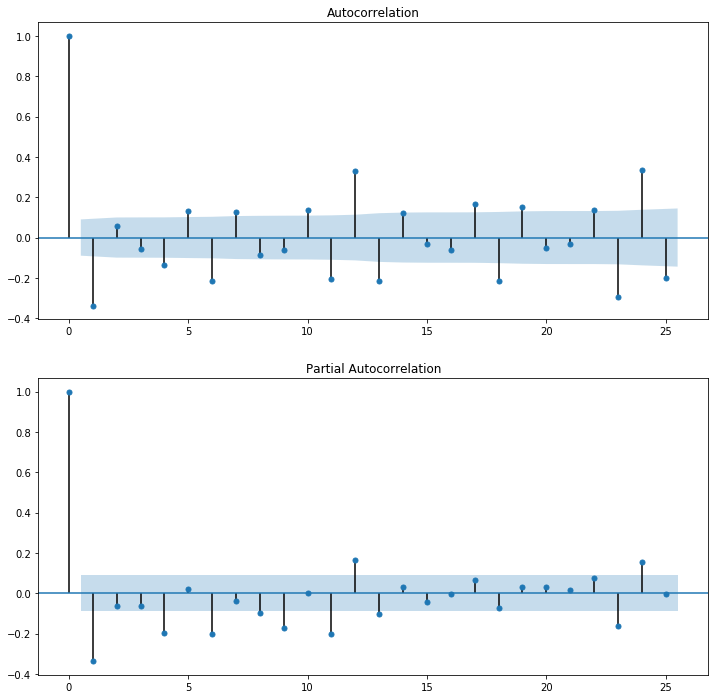

In [27]:
# ACF and PACF plots of the stationary time series
lags = 25
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(stationary_ns, lags=lags, ax=ax1)
plot_pacf(stationary_ns, lags=lags, ax=ax2)
plt.show()

### 3.d) Seasonal Decomposition for Seasonal Time Series Data

In [28]:
# Set the initial seasonal frequency parameter
seasonal_freq = 12

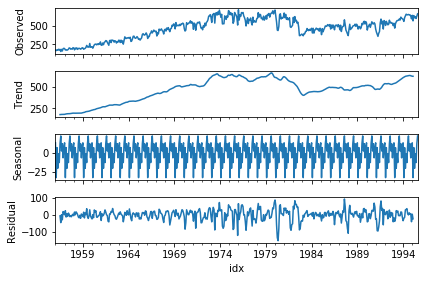

In [29]:
# Perform seasonal decomposition to observe the seasonal frequency
decomp_results = seasonal_decompose(time_series, freq=seasonal_freq)
decomp_results.plot()
plt.show()

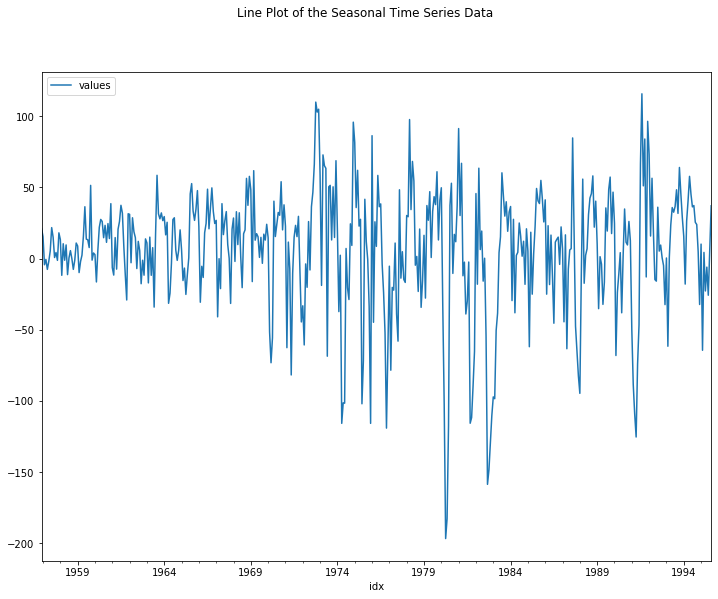

In [30]:
# Create a seasonal series
N = seasonal_freq
seasonal_series = time_series - time_series.rolling(N).mean()
seasonal_series = seasonal_series.dropna()

# Line plots of the seasonal time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Seasonal Time Series Data')
seasonal_series.plot(ax=ax)
plt.show()

In [31]:
# Check for stationarity
result = adfuller(seasonal_series[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.234041
p-value: 0.000007
Critical Test Statistics Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


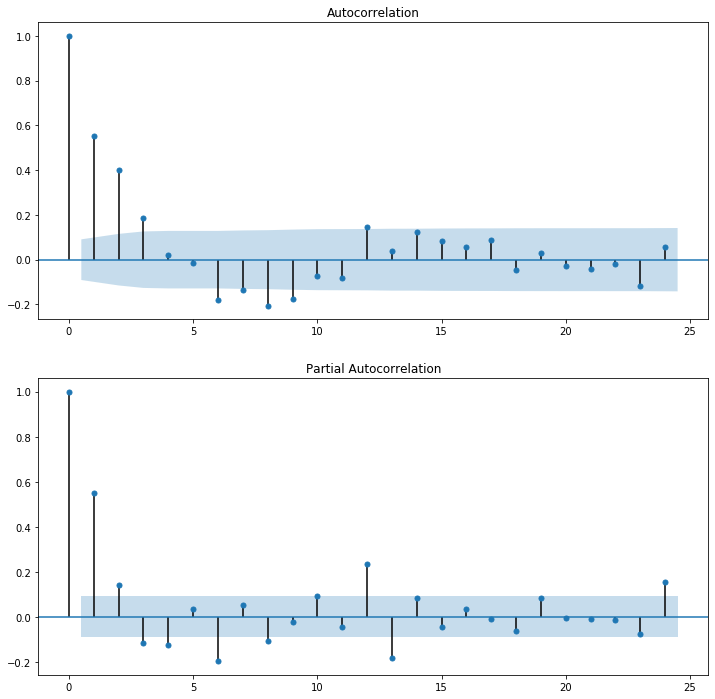

In [32]:
# ACF and PACF plots of the time series data
lag = seasonal_freq * 2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(seasonal_series, lags=lag, ax=ax1)
plot_pacf(seasonal_series, lags=lag, ax=ax2)
plt.show()

### 3.e) Test for Stationarity of Seasonal Time Series Data

Occasionally a time series may look non-stationary on the first look. We can make it stationary by differencing the series and using a statistical test to confirm that the differenced result is stationary. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

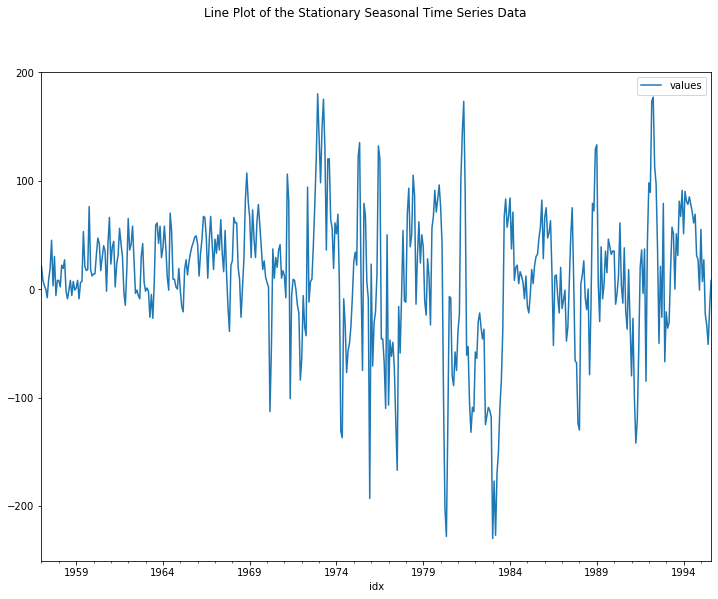

In [33]:
# Create a differenced series
stationary_ss = time_series.diff(seasonal_freq).dropna()

# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Seasonal Time Series Data')
stationary_ss.plot(ax=ax)
plt.show()

In [34]:
# Check for stationarity
result = adfuller(stationary_ss[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.685303
p-value: 0.000090
Critical Test Statistics Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


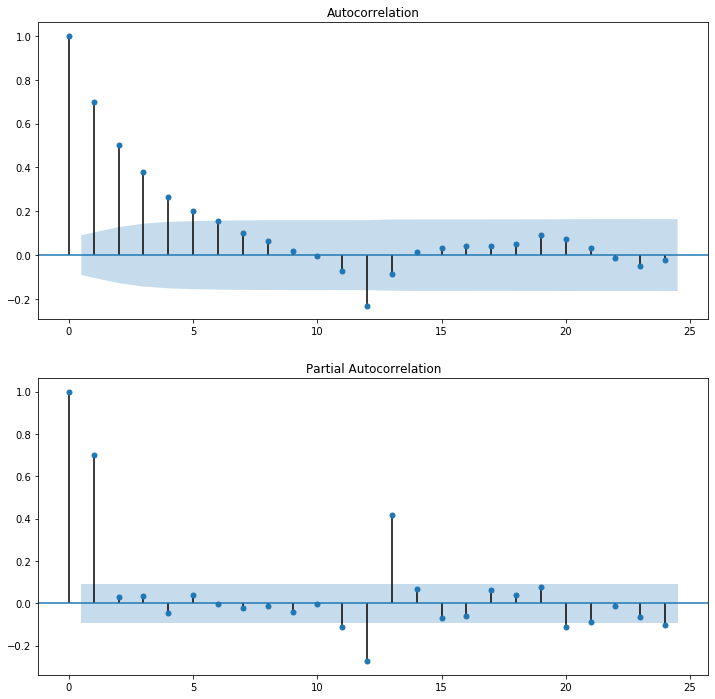

In [35]:
# ACF and PACF plots of the stationary time series
lags = seasonal_freq * 2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(stationary_ss, lags=lags, ax=ax1)
plot_pacf(stationary_ss, lags=lags, ax=ax2)
plt.show()

In [36]:
if (notifyStatus): email_notify("Data Cleaning and Pre-Processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 4. Fit and Evaluate Models

In this section, we will develop Autoregressive Integrated Moving Average or ARIMA models for the problem. We will first establish a persistent model. Next we will use a grid search approach to look for an optimal ARIMA model. This will be followed by a third step of investigating the residual errors of the chosen model.

* Establish the Persistent Model
* Automatically Configure the ARIMA
* Review Residual Errors

In [37]:
if (notifyStatus): email_notify("Model Fitting and Evaluation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Establish the Persistent Model

The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance. This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared.

The baseline prediction for time series forecasting is called the naive forecast, or persistence. This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

#### 4.a.iii) Establish the Persistent Model as Baseline

In [38]:
# Prepare and evaluate a persistence model
X = time_series.values
X = X.astype('float32')
train_pct = 0.80
train_size = int(len(X) * train_pct)
test_size = len(X) - train_size
train_ts, test_ts = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train_ts]
predictions = list()
for i in range(len(test_ts)):
    yhat = history[-1]
    predictions.append(yhat)
    obs = test_ts[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# Calculate performance
rmse = math.sqrt(mean_squared_error(test_ts, predictions))
print('RMSE for the persistent model is: %.3f' % rmse)

>Predicted=577.000, Expected=514
>Predicted=514.000, Expected=440
>Predicted=440.000, Expected=417
>Predicted=417.000, Expected=389
>Predicted=389.000, Expected=366
>Predicted=366.000, Expected=449
>Predicted=449.000, Expected=518
>Predicted=518.000, Expected=447
>Predicted=447.000, Expected=466
>Predicted=466.000, Expected=469
>Predicted=469.000, Expected=493
>Predicted=493.000, Expected=498
>Predicted=498.000, Expected=500
>Predicted=500.000, Expected=519
>Predicted=519.000, Expected=489
>Predicted=489.000, Expected=518
>Predicted=518.000, Expected=499
>Predicted=499.000, Expected=454
>Predicted=454.000, Expected=488
>Predicted=488.000, Expected=486
>Predicted=486.000, Expected=457
>Predicted=457.000, Expected=473
>Predicted=473.000, Expected=528
>Predicted=528.000, Expected=513
>Predicted=513.000, Expected=546
>Predicted=546.000, Expected=558
>Predicted=558.000, Expected=521
>Predicted=521.000, Expected=553
>Predicted=553.000, Expected=534
>Predicted=534.000, Expected=440
>Predicted

### 4.b) Grid Search of ARIMA Hyperparameters

We want to find a model that can do better than the persistence model on this dataset. To confirm this analysis, we can grid search a suite of ARIMA hyperparameters.

In this section, we will search values of p, d, and q for combinations (skipping those that fail to converge), and find the combination that results in the best performance. We will use a grid search to explore all combinations in a subset of integer values.

In [39]:
if (notifyStatus): email_notify("ARIMA Hyperparameters Search has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [40]:
# Set the initial P, D, and Q order parameters for non-seasonal ARIMA modeling
start_p = 0
start_d = None
start_q = 0
max_p = 5
max_d = 2
max_q = 5

In [41]:
# Set the initial P, D, and Q order parameters for seasonal ARIMA modeling
start_P = 0
start_D = None
start_Q = 0
max_P = 2
max_D = 1
max_Q = 2

In [42]:
# Testing the time series data for suggestions on the differencing term
start_d = pm.arima.ndiffs(train_ts)
print('The suggested non-seasonal differencing term is:', start_d)
if (seasonal_freq != 0):
    start_D = pm.arima.nsdiffs(train_ts, m = seasonal_freq)
    print('The suggested seasonal differencing term is:', start_D)

The suggested non-seasonal differencing term is: 1
The suggested seasonal differencing term is: 0


In [43]:
print('The initial non-seasonal parameters are: p =', start_p, '| d =', start_d, '| q =', start_q)
print('The maximum non-seasonal parameters are: max_p =', max_p, '| max_d =', max_d, '| max_q =', max_q)
print('The initial seasonal parameters are: P =', start_P, '| D =', start_D, '| Q =', start_Q, '| m =', seasonal_freq)
print('The maximum seasonal parameters are: max_P =', max_P, '| max_D =', max_D, '| max_Q =', max_Q)

The initial non-seasonal parameters are: p = 0 | d = 1 | q = 0
The maximum non-seasonal parameters are: max_p = 5 | max_d = 2 | max_q = 5
The initial seasonal parameters are: P = 0 | D = 0 | Q = 0 | m = 12
The maximum seasonal parameters are: max_P = 2 | max_D = 1 | max_Q = 2


In [44]:
# Do an automated stepwise search of ARIMA parameters
if (seasonal_freq == 0):
    stepwise_results = pm.auto_arima(train_ts, seasonal = False, stepwise = True, trace = True, suppress_warnings = True, random_state = seedNum)
else:
    stepwise_results = pm.auto_arima(train_ts, seasonal = True, m = seasonal_freq, stepwise = True, trace = True, suppress_warnings = True, random_state = seedNum)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=3776.483, BIC=3807.984, Fit time=1.548 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=3916.850, BIC=3924.725, Fit time=0.019 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=3841.034, BIC=3856.784, Fit time=0.453 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=3842.513, BIC=3858.263, Fit time=0.401 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=3830.353, BIC=3857.916, Fit time=1.581 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 1, 12); AIC=3778.218, BIC=3813.656, Fit time=5.902 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 0, 12); AIC=3819.309, BIC=3846.872, Fit time=2.059 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 2, 12); AIC=3778.239, BIC=3813.677, Fit time=5.827 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 12); AIC=3851.519, BIC=3875.145, Fit time=0.537 seconds
Fit ARIMA: order=(2, 1, 2) s

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  380
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1880.307
Date:                            Tue, 12 Nov 2019   AIC                           3772.614
Time:                                    13:34:00   BIC                           3796.239
Sample:                                         0   HQIC                          3781.989
                                            - 380                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0069      0.028      0.245      0.807      -0.048       0.062
ar.L1          0.6393      0.053   

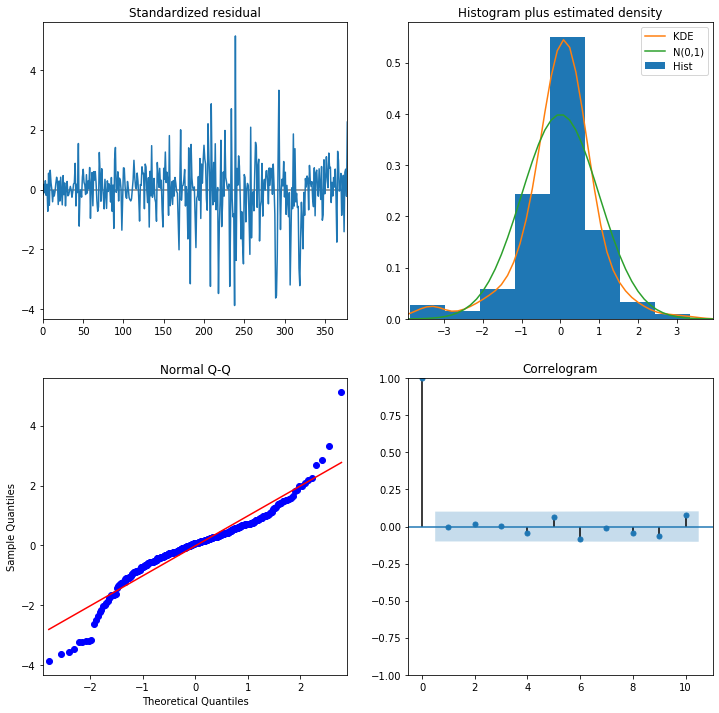

In [45]:
# Summarize residual errors for the automated grid search ARIMA model
print(stepwise_results.summary())
stepwise_results.plot_diagnostics(figsize=(12,12))
plt.show()

In [46]:
if (notifyStatus): email_notify("ARIMA automated stepwise search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [47]:
# Do an automated random search of ARIMA parameters
n_fits = int(max_p * max_d * max_q * max_P * max_D * max_Q * 0.30)
if (seasonal_freq == 0):
    randgrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = False, stepwise = False, random = True, n_fits = n_fits, max_order = None,
                                     trace = True, suppress_warnings = True, random_state = seedNum)
else:
    randgrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = True, m = seasonal_freq, start_P = start_P, D = start_D, start_Q = start_Q, max_P = max_P, max_D = max_D, max_Q = max_Q,
                                     stepwise = False, random = True, n_fits = n_fits, max_order = None,
                                     trace = True, suppress_warnings = True, random_state = seedNum)

Fit ARIMA: order=(3, 1, 4) seasonal_order=(1, 0, 1, 12); AIC=3771.551, BIC=3814.864, Fit time=4.061 seconds
Fit ARIMA: order=(5, 1, 0) seasonal_order=(2, 0, 1, 12); AIC=3791.518, BIC=3830.893, Fit time=6.869 seconds
Fit ARIMA: order=(5, 1, 5) seasonal_order=(2, 0, 0, 12); AIC=3781.633, BIC=3836.759, Fit time=10.484 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 2, 12); AIC=3833.677, BIC=3853.365, Fit time=1.180 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(1, 0, 1, 12); AIC=3778.519, BIC=3813.956, Fit time=2.767 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=3866.444, BIC=3878.256, Fit time=0.094 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 1, 12); AIC=3850.230, BIC=3865.980, Fit time=0.366 seconds
Fit ARIMA: order=(3, 1, 5) seasonal_order=(2, 0, 2, 12); AIC=3777.404, BIC=3832.530, Fit time=11.527 seconds
Fit ARIMA: order=(1, 1, 4) seasonal_order=(0, 0, 1, 12); AIC=3830.330, BIC=3861.831, Fit time=1.614 seconds
Fit ARIMA: order=(1, 1, 0)

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  380
Model:             SARIMAX(3, 1, 4)x(1, 0, 1, 12)   Log Likelihood               -1874.776
Date:                            Tue, 12 Nov 2019   AIC                           3771.551
Time:                                    13:38:25   BIC                           3814.864
Sample:                                         0   HQIC                          3788.740
                                            - 380                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0116      0.040      0.288      0.774      -0.068       0.091
ar.L1         -1.0069      0.100   

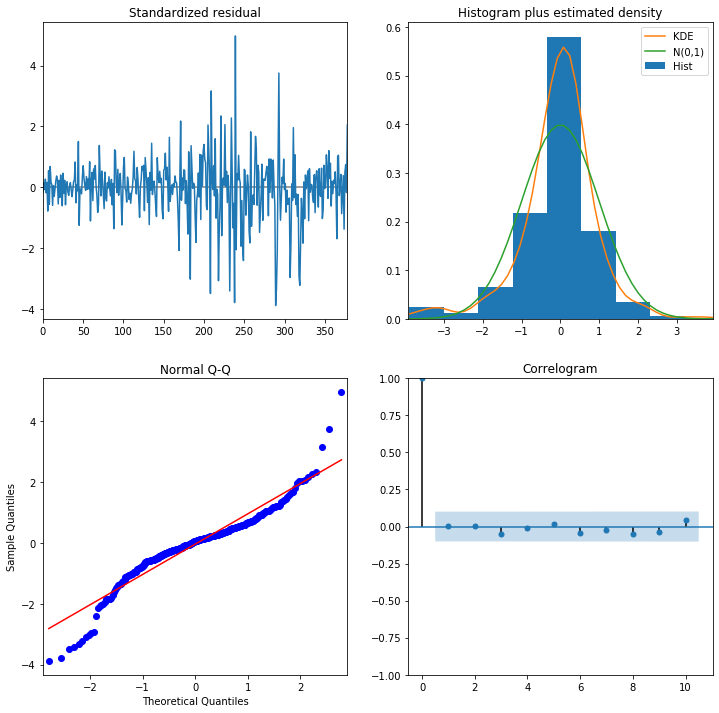

In [48]:
# Summarize residual errors for the automated grid search ARIMA model
print(randgrid_results.summary())
randgrid_results.plot_diagnostics(figsize=(12,12))
plt.show()

In [49]:
if (notifyStatus): email_notify("ARIMA automated random search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [50]:
# Do an automated grid search of ARIMA parameters
if (seasonal_freq == 0):
    autogrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = False, stepwise = False, max_order = None, trace = True, suppress_warnings = True, random_state = seedNum)
else:
    autogrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = True, m = seasonal_freq, start_P = start_P, D = start_D, start_Q = start_Q, max_P = max_P, max_D = max_D, max_Q = max_Q,
                                     stepwise = False, max_order = None, trace = True, suppress_warnings = True, random_state = seedNum)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=3916.850, BIC=3924.725, Fit time=0.021 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 12); AIC=3886.700, BIC=3898.513, Fit time=0.259 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 2, 12); AIC=3859.932, BIC=3875.682, Fit time=0.814 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=3867.354, BIC=3879.167, Fit time=0.333 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 12); AIC=3805.465, BIC=3821.215, Fit time=0.542 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 2, 12); AIC=3807.465, BIC=3827.153, Fit time=2.151 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 0, 12); AIC=3838.127, BIC=3853.877, Fit time=1.093 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 1, 12); AIC=3807.465, BIC=3827.153, Fit time=2.297 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 2, 12); AIC=3808.045, BIC=3831.670, Fit time=1.893 seconds
Fit ARIMA: order=(0, 1, 1) s

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  380
Model:             SARIMAX(3, 1, 4)x(1, 0, 1, 12)   Log Likelihood               -1874.776
Date:                            Tue, 12 Nov 2019   AIC                           3771.551
Time:                                    14:01:30   BIC                           3814.864
Sample:                                         0   HQIC                          3788.740
                                            - 380                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0116      0.040      0.288      0.774      -0.068       0.091
ar.L1         -1.0069      0.100   

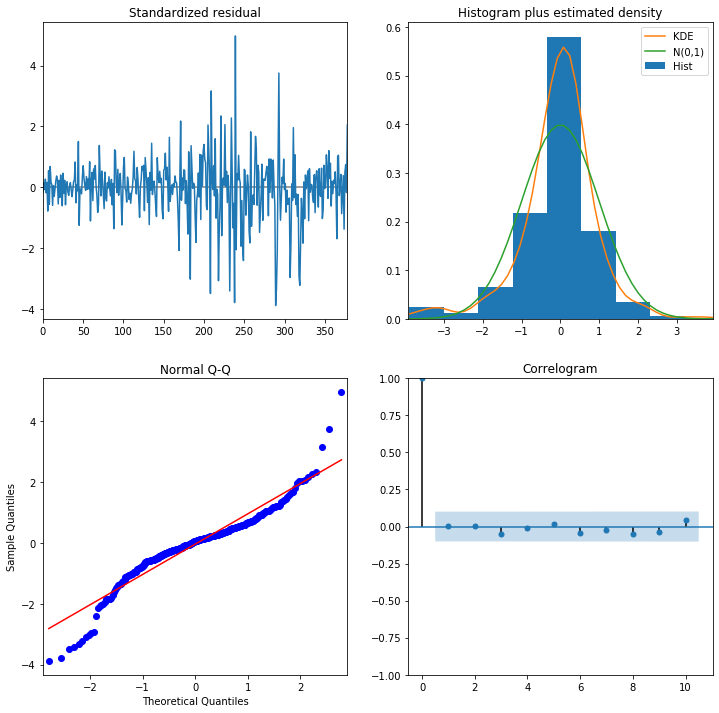

In [51]:
# Summarize residual errors for the automated grid search ARIMA model
print(autogrid_results.summary())
autogrid_results.plot_diagnostics(figsize=(12,12))
plt.show()

In [52]:
if (notifyStatus): email_notify("ARIMA automated grid search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [53]:
# Not applicable for this iteration of the project

# Set up the function to handle the ARIMA calculation
# def Calculate_ARIMA(ns_order, ss_order):
#     startTimeModel = datetime.now()
#     aic_score, bic_score = float("inf"), float("inf")
#     if (verbose): print('Trying to fit the model with parameters:', ns_order, ss_order)
#     try:
#         if (ss_order[3] == 0): grid_model = SARIMAX(train_ts, order=ns_order)
#         else: grid_model = SARIMAX(train_ts, order=ns_order, seasonal_order=ss_order)
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             grid_results = grid_model.fit(disp = False)
#         aic_score = grid_results.aic
#         bic_score = grid_results.bic
#         if (verbose): print('Fit ARIMA: order=%s seasonal_order=%s; AIC=%.3f, BIC=%.3f, Fit time=%s' % 
#               (ns_order, ss_order, aic_score, bic_score, (datetime.now() - startTimeModel)))
#         return(aic_score, bic_score)
#     except:
#         return(float("inf"), float("inf"))

In [54]:
# Not applicable for this iteration of the project

# Do a manual grid search of ARIMA parameters
# best_score, best_ns_cfg, best_ss_cfg = float("inf"), None, None
# for p in range(start_p, max_p+1):
#     for d in range(start_d, max_d+1):
#         for q in range(start_q, max_q+1):
#             for P in range(start_P, max_P+1):
#                 for D in range(start_D, max_D+1):
#                     for Q in range(start_Q, max_Q+1):
#                         ns_order = (p, d, q)
#                         ss_order = (P, D, Q, seasonal_freq)
#                         aic_score, bic_score = Calculate_ARIMA(ns_order, ss_order)
#                         if (aic_score < best_score):
#                             best_ns_cfg, best_ss_cfg, best_score = ns_order, ss_order, aic_score
#                             print('A better model found: order=%s seasonal_order=%s; AIC=%.3f, BIC=%.3f' % (ns_order, ss_order, aic_score, bic_score))
# print('Best ARIMA model via manual search: order=%s seasonal_order=%s; AIC=%f' % (best_ns_cfg, best_ss_cfg, best_score))

In [55]:
# Summarize residual errors for the manual ARIMA model
# manual_model = SARIMAX(train_ts, order=best_ns_cfg, seasonal_order=best_ss_cfg)
# manual_results = manual_model.fit(disp = False)
# print(manual_results.summary())
# manual_results.plot_diagnostics(figsize=(12,12))
# plt.show()

In [56]:
if (notifyStatus): email_notify("ARIMA Hyperparameters Search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.c) Evaluate the Residual Errors

A good final check of a model is to review residual forecast errors. Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

In [57]:
# Set the ARIMA order parameters for validation and forecasting
final_ns_order = stepwise_results.order
final_ss_order = stepwise_results.seasonal_order
# final_ns_order = randgrid_results.order
# final_ss_order = randgrid_results.seasonal_order
# final_ns_order = autogrid_results.order
# final_ss_order = autogrid_results.seasonal_order
# final_ns_order = best_ns_cfg
# final_ss_order = best_ss_cfg
print("Final Non-season order:", final_ns_order, 'Final Seasonal Order:', final_ss_order)

Final Non-season order: (1, 1, 1) Final Seasonal Order: (1, 0, 1, 12)


C:\Users\david\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                             values   No. Observations:                  476
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2357.335
Date:                            Tue, 12 Nov 2019   AIC                           4724.671
Time:                                    14:01:32   BIC                           4745.487
Sample:                                01-01-1956   HQIC                          4732.857
                                     - 08-01-1995                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6298      0.047     13.357      0.000       0.537       0.722
ma.L1         -0.8857      0.035   

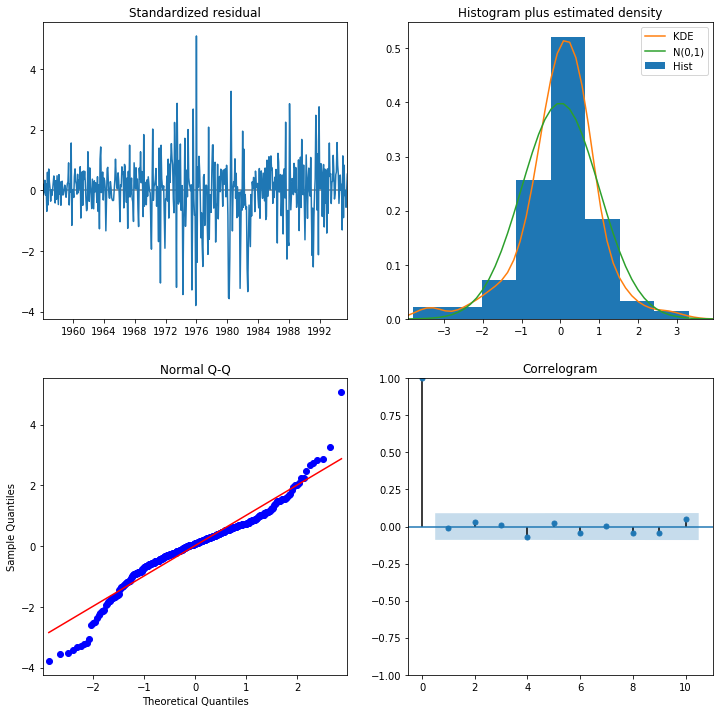

In [58]:
# Summarize residual errors for the final ARIMA model
final_model = SARIMAX(time_series, order=final_ns_order, seasonal_order=final_ss_order)
final_results = final_model.fit(disp = False)
print(final_results.summary())
final_results.plot_diagnostics(figsize=(12,12))
plt.show()

In [59]:
if (notifyStatus): email_notify("Model Fitting and Evaluation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 5. Finalize Model

After models have been developed and a final model selected, it must be validated and finalized. Validation is an optional part of the process, but one that provides a ‘last check’ to ensure we have not fooled or lied to ourselves.

In [60]:
if (notifyStatus): email_notify("Model Finalization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Validation via In-sample Data

In [61]:
forecast = final_results.get_prediction(start = -test_size)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

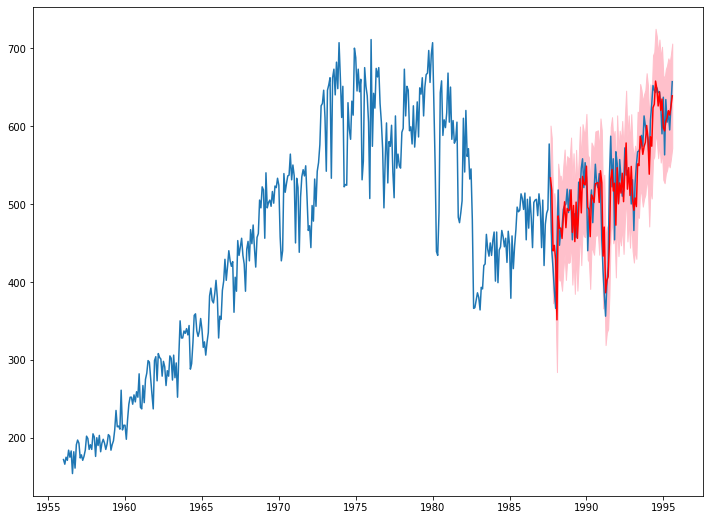

In [62]:
plt.figure(figsize=(12,9))
plt.plot(time_series.index, time_series[target_col], label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')
plt.fill_between(confidence_intervals.index, confidence_intervals[lower_bound], confidence_intervals[upper_bound], color='pink')
plt.show()

In [63]:
# Evaluate RMSE for the validation data
y = time_series[-test_size:]
predictions = mean_forecast.values
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE from the validation data is: %.3f' % rmse)

RMSE from the validation data is: 34.639


### 5.b) Forecasting Out-of-Sample Data

In [64]:
forecast = final_results.get_forecast(steps = test_size)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

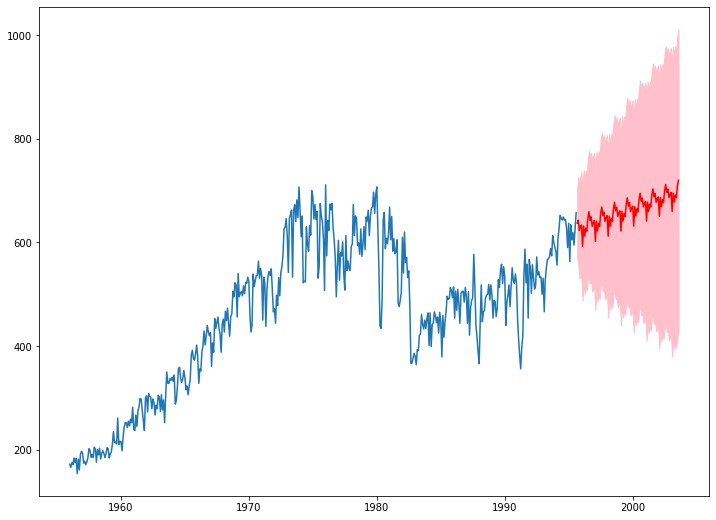

In [65]:
plt.figure(figsize=(12,9))
plt.plot(time_series.index, time_series[target_col], label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')
plt.fill_between(confidence_intervals.index, confidence_intervals[lower_bound], confidence_intervals[upper_bound], color='pink')
plt.show()

In [66]:
if (notifyStatus): email_notify("Model Finalization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [67]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:28:31.321268
